In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gurobipy import GRB
from utils import file_reader as fr
from utils import data_generator as dg
from utils import problem_model as pm


# Model practability

We now loook at at the practability, from a computational viewpoint, of the previous presented MSPP-PD models.  

To do so we consider different combination of increasing larger network sizes and network congestion and then we examine the average time that each type of variant of MSPP-PD problem takes to be solved.  
For this analysis we've examined 10 different network instances for each network-type and congestion-level combination.

The networks that we analyze have the same topology of the networks used on the previous notebooks


## Read data

We start by loading the network instances:  
- For each network size $(m,n) \in \{(6,6), (8,8), (10,10), (12,12)\}$ we load the dataframe that contains all the instaces for that type of network;
- And then we append each dataframe to a list that will be used to define a dictionary that map each network type to its dataframe containing the instances


In [2]:
network_types = ["6x6", "8x8", "10x10", "12x12"]
idx_of_network_type = dict(zip(network_types, range(len(network_types))))
network_dfs = []

for network_type in network_types:
    network_filename = f"data/d_it_ij_{network_type}_10it.csv"
    network_dfs.append(fr.read_networks_csv(network_filename,
                                            along="cols"))

network_type_to_its_df = dict(zip(network_types, network_dfs))

# an example of 5 instances from a network dataframe
network_type_to_its_df["6x6"].head()


0                   1                             2             \
           6         7         6         7         8         7         8    
it1  1.612014  1.281732  1.512410  1.612053  0.495080  1.633618  0.282487   
it2  0.345666  1.549119  1.935411  1.664691  1.150243  1.346757  0.790995   
it3  1.059043  0.470901  0.397252  0.210863  0.720249  0.926994  1.987635   
it4  0.297746  1.561490  0.480028  0.058043  1.032561  1.155090  0.997398   
it5  1.296527  0.536009  0.439805  0.458544  1.420302  0.178641  0.108120   

                     3             ...        26                  27  \
           9         8         9   ...        32        33        32   
it1  1.570645  0.398975  0.890572  ...  0.491645  1.860557  0.792445   
it2  0.558598  1.677854  0.874843  ...  1.001069  0.476828  0.640806   
it3  0.360284  0.508765  1.101995  ...  1.213463  1.572754  1.330204   
it4  0.577482  1.140927  0.833327  ...  0.279092  1.068302  1.286386   
it5  0.772551  1.102323  0.592525  ...  0.652133  0.808668  1.197061   

                               28                            29            
           33        34        33        34        35        34        35  
it1  0.644937  0.296105  1.470566  1.336894  1.595893  0.273600  1.416396  
it2  1.368508  0.503312  0.577109  1.779668  1.729859  0.117643  0.830738  
it3  0.851481  1.894534  1.456438  1.425572  1.092434  1.438385  0.934447  
it4  0.255251  0.459456  1.479642  1.490551  0.335991  1.382244  1.578896  
it5  0.794697  0.263786  1.622354  1.549742  1.855342  0.732395  0.670513  

[5 rows x 80 columns]

## Manage datas

Here we define variables that will be used in the analysis


Since to analyze all combination for 10 instances takes too long on our machine, we'll run the analysis on a subset of network instances


In [3]:
num_instances = 5


Define the different MSPP-PD variants and the different level of network congestions to test

In [4]:
problem_types = ["ABP", "NBP", "ALP", "NLP", "AQP", "NQP"]
idx_of_pb_type = dict(zip(problem_types, range(len(problem_types))))


congestion_levels = [0.5, 1, 1.5, 2]
idx_of_congestion_lvl = dict(zip(congestion_levels, range(len(congestion_levels))))


As done in section 3.4 of the paper we limit the run time for solving the problems to 10min and we take note of those not solved within the time limit


In [5]:
time_limit = 10 * 60  # (s)

# store the problems convergence time for each case
convergence_times_shape = (len(network_types),      # each network type
                           num_instances,           # has a number of different instances
                           len(problem_types),      # and we'll solve a MSPP-PD variant
                           len(congestion_levels))  # for different number of agents in the network
convergence_times = np.full(convergence_times_shape, fill_value=np.nan)


# store the number of problems that did not converge within the time limit
# for each (network_type, problem_type, congestion level) case
num_of_unsolved_problems_shape = (len(network_type),
                                  len(problem_types),
                                  len(congestion_levels))
num_of_unsolved_problems = np.zeros(num_of_unsolved_problems_shape, dtype=int)


## Solve problems

Solve each combination and compute its comvergence time


In [ ]:
# skip this cell if you want to use pre-computed results

for network_type in network_types:

     # subset of instances to test
     networks_df = network_type_to_its_df[network_type].head(num_instances)
     
     networks_shape = [int(i) for i in network_type.split("x")]
     network_nodes = dg.get_nodes(networks_df)

     for it_i, network_arcs in enumerate(dg.network_instances(networks_df)):

          print(f"Testing instance {it_i} of {network_type} networks...")

          for pb_type in problem_types:
               
               for congestion_lvl in congestion_levels:

                    # define the agents that has to be routed as explained in section 3.3 of the paper
                    num_of_agents = int(networks_shape[0] * congestion_lvl)
                    agents = dg.generate_agents(networks_shape, num_of_agents)

                    pb, x, *_ = pm.set_problem(pb_type, network_nodes, network_arcs, agents)
                    pb.Params.TimeLimit = time_limit
                    pb.optimize()

                    if pb.status == GRB.OPTIMAL:
                         convergence_times[idx_of_network_type[network_type],
                                           it_i,
                                           idx_of_pb_type[pb_type],
                                           idx_of_congestion_lvl[congestion_lvl]] = pb.runtime
                    elif pb.status == GRB.TIME_LIMIT:
                         convergence_times[idx_of_network_type[network_type],
                                           it_i,
                                           idx_of_pb_type[pb_type],
                                           idx_of_congestion_lvl[congestion_lvl]] = pb.runtime
                         
                         print(f"A {pb_type} problem exceeded the time limit on a {network_type} network with {len(agents)} agents.")
                         num_of_unsolved_problems[idx_of_network_type[network_type],
                                                  idx_of_pb_type[pb_type],
                                                  idx_of_congestion_lvl[congestion_lvl]] += 1
                    else:
                         raise Exception(f"AAA: A {pb_type} problem on a {network_type} network with {len(agents)} agents encounterd problems")
                    

If desired we can store results in order to avoid waiting for computations each time we run the notebook

In [ ]:
# np.save(
#     f"results/models_convergence_times_{num_instances}.npy", convergence_times)

# np.save(
#     f"results/num_of_unsolved_problems_{num_instances}.npy", num_of_unsolved_problems)


## Final statistic

In the following we report the average convergence time (s) for MSPP-PD model variants' for different network sizes and congestion levels


If wanted we can load the stored results and rely on them


In [6]:
convergence_times = np.load(
    f"results/models_convergence_times_{num_instances}.npy")

num_of_unsolved_problems = np.load(
    f"results/num_of_unsolved_problems_{num_instances}.npy")


Print the results (along rows we have the variant of the model and along columns we have the different congestion levels)


In [7]:
avg_convergence_times = np.nanmean(convergence_times, axis=1)

for network_type in network_types:
    network_avg_convergence_time = avg_convergence_times[idx_of_network_type[network_type], :, :]
    network_avg_convergence_time_df = pd.DataFrame(network_avg_convergence_time,
                                                   columns=congestion_levels,
                                                   index=problem_types)
    print(f"Average convercenge times for {network_type} networks:")
    print(network_avg_convergence_time_df)
    print()


Average convercenge times for 6x6 networks:
          0.5       1.0       1.5       2.0
ABP  0.011531  0.015546  0.220229  0.651739
NBP  0.007235  0.052239  0.124851  0.293900
ALP  0.008476  0.010300  0.015116  0.022482
NLP  0.005819  0.015743  0.055010  0.063636
AQP  0.007360  0.025161  0.353151  2.878807
NQP  0.011718  0.050938  0.902835  9.369259

Average convercenge times for 8x8 networks:
          0.5       1.0        1.5         2.0
ABP  0.013265  0.043556   1.797845    8.458114
NBP  0.058450  1.175745   0.480468    4.086706
ALP  0.010696  0.023081   0.038662    0.056559
NLP  0.037971  0.234689   0.380421    0.522053
AQP  0.029858  0.109738   4.720424   34.743172
NQP  0.063392  0.906801  20.830824  420.861859

Average convercenge times for 10x10 networks:
          0.5        1.0         1.5         2.0
ABP  0.096985   0.694881   10.053558  103.570176
NBP  0.253508   5.684336   15.564477   22.536368
ALP  0.023549   0.039071    0.082137    0.135093
NLP  0.071816   2.254453    5.9

And visualize the results, to compare the average convergence times 


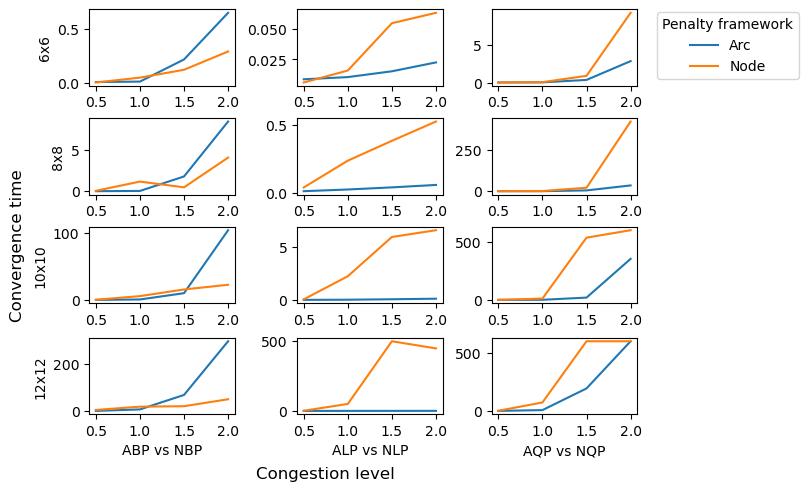

In [8]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst.
    
    Args:
        lst (list): list that has to be read in chunks
        n (int): number of list's items that will be present on a single chunk
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


fig, axs = plt.subplots(4, 3, layout="constrained")

for row, network_type in enumerate(network_types):
    for col, (arc_pb, node_pb) in enumerate(chunks(problem_types,2)):
        
        arc_pb_times = avg_convergence_times[idx_of_network_type[network_type],
                                        idx_of_pb_type[arc_pb],
                                        :]
        
        node_pb_times = avg_convergence_times[idx_of_network_type[network_type],
                                        idx_of_pb_type[node_pb],
                                        :]

        axs[row,col].plot(congestion_levels, arc_pb_times, label="Arc")
        axs[row,col].plot(congestion_levels, node_pb_times, label="Node")

        # avg convergence times are computed just for certain congestion levels
        axs[row,col].xaxis.set_ticks(congestion_levels)  # set plots' x-axis
        
        plt.setp(axs[-1, col], xlabel=f"{arc_pb} vs {node_pb}")
    
    plt.setp(axs[row, 0], ylabel=f"{network_type}")

# common axis labels
fig.supxlabel('Congestion level')
fig.supylabel('Convergence time')    

handles, labels = axs[row,col].get_legend_handles_labels()
fig.legend(handles, labels, title="Penalty framework", bbox_to_anchor=(1.25, 1))

plt.show()

In [9]:
for network_type in network_types:
    unsolved_problems_df = pd.DataFrame(num_of_unsolved_problems[idx_of_network_type[network_type], :, :],
                                        columns=congestion_levels,
                                        index=problem_types)
    print(
        f"Number of unsolved problems within the {time_limit}s time limit for {network_type} networks:")
    print(unsolved_problems_df)
    print()


Number of unsolved problems within the 600s time limit for 6x6 networks:
     0.5  1.0  1.5  2.0
ABP    0    0    0    0
NBP    0    0    0    0
ALP    0    0    0    0
NLP    0    0    0    0
AQP    0    0    0    0
NQP    0    0    0    0

Number of unsolved problems within the 600s time limit for 8x8 networks:
     0.5  1.0  1.5  2.0
ABP    0    0    0    0
NBP    0    0    0    0
ALP    0    0    0    0
NLP    0    0    0    0
AQP    0    0    0    0
NQP    0    0    0    3

Number of unsolved problems within the 600s time limit for 10x10 networks:
     0.5  1.0  1.5  2.0
ABP    0    0    0    0
NBP    0    0    0    0
ALP    0    0    0    0
NLP    0    0    0    0
AQP    0    0    0    2
NQP    0    0    4    5

Number of unsolved problems within the 600s time limit for 12x12 networks:
     0.5  1.0  1.5  2.0
ABP    0    0    0    2
NBP    0    0    0    0
ALP    0    0    0    0
NLP    0    0    3    3
AQP    0    0    1    5
NQP    0    0    5    5



As can be seen from the results above both network size and number of agents to route, generally, combine to increse the time to convergence for all MSPP-PD model variants.  
We can also notice that the only 2 formulations that converge for all instances were MSPP-PD(NBP) and MSPP-PD(ALP), but more in general, except for the binary framework, we can state that the arc-specific penalty metrics converge faster than their node counterparts (glaring is the case of the $12 \times 12$ network where the MSPP-PD(ALP) variant can outperform by 3 orders of magnitude its node counterpart).
